# 🧠 Kor-DEEPression
## 📊 Step 2-5. Compare Models<br>(모델 비교분석 및 최종모델 선정)
> 🍷 작성자 : Codestates AIB 15기 정경재 (Kyung Jae, Cheong)
---

### 0. 💻 라이브러리 불러오기

- 💻 Library Import (라이브러리 불러오기)

In [1]:
# 데이터 관련 Library Import
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 시각화 관련 Library Import
import matplotlib.pyplot as plt
import seaborn as sns
# Matplotlib setting for VSCode
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Model 불러오기 관련 Library Import
import pickle
from keras.models import load_model

# Cross Validation 관련 Library Import
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Cross Validation 시각화 관련 Library Import
from sklearn.metrics import roc_curve, confusion_matrix

- 📝 진행순서
    - 데이터를 불러온 뒤 학습,검증,예측용 데이터에 대한 EDA(탐색적분석) 실시
    - 데이터 분리(Train & Test) 후 Baseline Model(최빈 Class) 정의
    - 튜닝 후 저장된 데이터를 불러온 뒤 Cross-validation 실시
    - 성능 비교 분석 후 최종 모델 선정
    - 최종 모델 예측 테스트 실시
---

### 🧠 Depression (정상 vs 우울증)

#### 1-1. 💾 데이터 불러오기

In [3]:
# 전처리를 마친 데이터를 불러오기
df_depr = pd.read_csv("./downloads/Encoded_depr.csv")
print(f"Depression Dataset Shape : {df_depr.shape}")

Depression Dataset Shape : (16570, 48)


#### 1-2. ⚙️ Feature, Target 분리

In [11]:
# Feature, Target 분리
features_depr = df_depr.drop(columns='depression')
target_depr = df_depr['depression']
# Shape 확인
print(f"분리 전 Shape : {df_depr.shape}")
print(f"\n분리 후 Shape : {features_depr.shape}, {target_depr.shape}")

분리 전 Shape : (16570, 48)

분리 후 Shape : (16570, 47), (16570,)


#### 1-3. 📊 Target 분포 확인

In [12]:
# Target 수 확인
count_depr = target_depr.value_counts().sort_index()
print("Target(depression) 수")
print(count_depr)
# Target 비율 확인
ratio_depr = target_depr.value_counts(normalize=True).sort_index()
print("\nTarget(depression) 비율")
print(ratio_depr)

Target(depression) 수
0    13211
1     3359
Name: depression, dtype: int64

Target(depression) 비율
0    0.797284
1    0.202716
Name: depression, dtype: float64


Target(depression) 수
0    13211
1     3359
Name: depression, dtype: int64


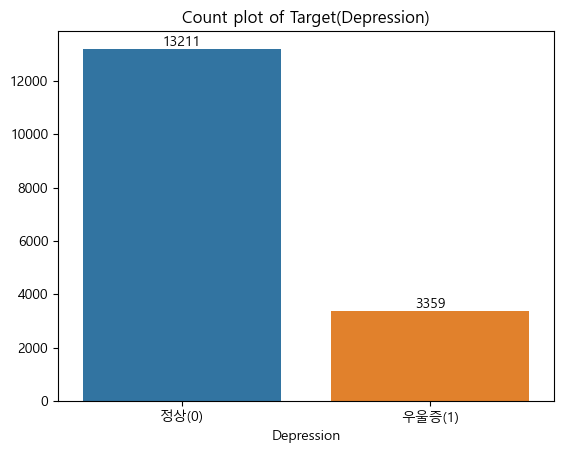

In [13]:
# label 정의
label_depr = ['정상(0)', '우울증(1)']
# Target 수
print("Target(depression) 수")
print(count_depr)
# 시각화 (빈도)
ax_bar_depr = sns.countplot(x=target_depr)
ax_bar_depr.bar_label(ax_bar_depr.containers[0])
plt.xticks([0,1], label_depr)
plt.title("Count plot of Target(Depression)")
plt.xlabel("Depression")
plt.ylabel("")
plt.show()


Target(depression) 비율
0    0.797284
1    0.202716
Name: depression, dtype: float64


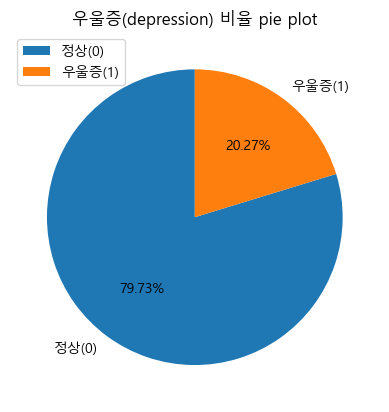

In [10]:
# Target 비율
print("\nTarget(depression) 비율")
print(ratio_depr)
# 시각화 (비율)
plt.pie(x = count_depr, labels=label_depr, autopct='%.2f%%', startangle=90)
plt.legend(loc = 'upper left')
plt.title('우울증(depression) 비율 pie plot')
plt.show()

#### 1-4. 🔎 Feature 분포 확인

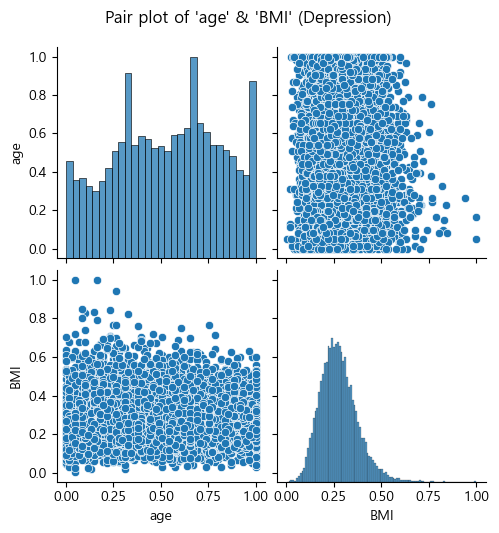

In [15]:
# 수치형변수(age, BMI) 분포, 상관관계 시각화
num_feat = ['age', 'BMI']
sns.pairplot(features_depr[num_feat])
plt.suptitle("Pair plot of 'age' & 'BMI' (Depression)", y=1.05)
plt.show()

In [16]:
# Feature Column 표준화 여부 확인 (min, max 값 확인)
print(f"Feature Min Value : {features_depr.min().min()}")
print(f"Feature Max Value : {features_depr.max().max()}")

Feature Min Value : 0.0
Feature Max Value : 1.0


#### 1-5. ⚙️ Train, Test 데이터 분리

In [17]:
# Train, Test 분리 (test 비율 20%, seed=2023)
X_train_depr, X_test_depr, y_train_depr, y_test_depr = train_test_split(
    features_depr, target_depr, test_size=0.2, random_state=2023)

print('X_train_depr : {}'.format(X_train_depr.shape))
print('y_train_depr : {}'.format(y_train_depr.shape))
print('\nX_test_depr : {}'.format(X_test_depr.shape))
print('y_test_depr : {}'.format(y_test_depr.shape))

X_train_depr : (13256, 47)
y_train_depr : (13256,)

X_test_depr : (3314, 47)
y_test_depr : (3314,)


In [18]:
# Train, Test의 Target 데이터 비율 확인
print("Depression - Train")
print(y_train_depr.value_counts(normalize=True))
print("\nDepression - Test")
print(y_test_depr.value_counts(normalize=True))

Depression - Train
0    0.79564
1    0.20436
Name: depression, dtype: float64

Depression - Test
0    0.803862
1    0.196138
Name: depression, dtype: float64


#### 1-6. ⚙️ Baseline Model 정의 (최빈 Class 비율)

In [24]:
# 최빈값 지정 및 Baseline 모델 정의
mode_depr = y_train_depr.mode()[0]
baseline_depr = [mode_depr]*len(y_train_depr)
# Baseline Accuracy & ROC_AUCscore 산출
baseline_acc_depr = accuracy_score(y_train_depr, baseline_depr)
baseline_AUC_depr = roc_auc_score(y_train_depr, baseline_depr)
print("[Depression]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_depr))
print("Baseline AUC_score : {}".format(baseline_AUC_depr))

[Depression]
Baseline Accuracy : 0.7956
Baseline AUC_score : 0.5


#### 2-1. 🛠️ Cross-Validation (Depression)<br>Logistic Regression

- Accuracy (정확도)

In [26]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_logistic_depr = pickle.load(open("../tuning-models/Logistic_depr.pkl", "rb"))

# 학습 실시 (Fit)
model_logistic_depr.fit(X_train_depr, y_train_depr)

# CV Accuracy(정확도) 산출 (cv=4)
CV_acc_logistic_depr = cross_val_score(estimator = model_logistic_depr,
                                       X=X_train_depr, y=y_train_depr,
                                       cv=4, n_jobs=-1, scoring='accuracy')
print("[Depression]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_depr))
print("LogisticRegression Accuracy : {:.4f}".format(CV_acc_logistic_depr.mean()))

[Depression]
Baseline Accuracy : 0.7956
LogisticRegression Accuracy : 0.8300


- CV Prediction (교차검증 예측)

In [27]:
# CV prediction 실시
CV_pred_logistic_depr = cross_val_predict(estimator = model_logistic_depr,
                                          X=X_train_depr, y=y_train_depr,
                                          cv=4, n_jobs=-1)
# Table을 통해 확인해보기
df_pred_logistic_depr = pd.DataFrame(data={'true_depr': y_train_depr,
                                           'pred_depr': CV_pred_logistic_depr})
table_pred_logistic_depr = pd.crosstab(df_pred_logistic_depr['true_depr'],
                                       df_pred_logistic_depr['pred_depr'])
display(table_pred_logistic_depr)

pred_depr,0,1
true_depr,,
0,10101,446
1,1808,901


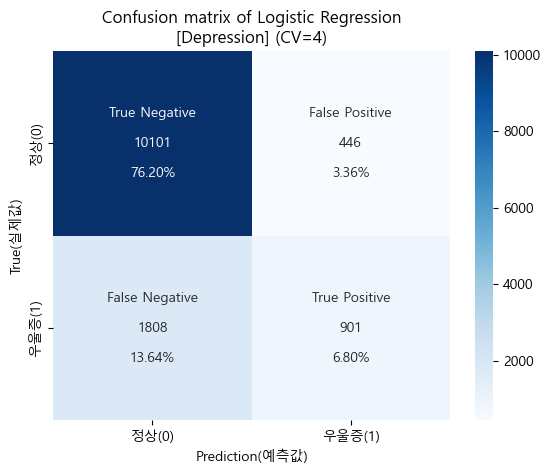

In [28]:
# Confusion matrix (혼동행렬)
cfm_logistic_depr = confusion_matrix(y_train_depr, CV_pred_logistic_depr)

# 시각화에 표시할 값들을 정의하기
group_names_logistic_depr = ['True Negative','False Positive','False Negative','True Positive']
group_counts_logistic_depr = ['{0:0.0f}'.format(value) for value in cfm_logistic_depr.flatten()]
group_percent_logistic_depr = ['{0:.2%}'.format(value) for value in cfm_logistic_depr.flatten()/np.sum(cfm_logistic_depr)]

labels_logistic_depr = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_logistic_depr,
                                                                    group_counts_logistic_depr,
                                                                    group_percent_logistic_depr)]
labels_logistic_depr = np.asarray(labels_logistic_depr).reshape(2,2)

tick_logistic_depr = ['정상(0)', '우울증(1)']

# 시각화(heatmap)
sns.heatmap(cfm_logistic_depr, annot=labels_logistic_depr, fmt='', cmap='Blues',
            xticklabels=tick_logistic_depr, yticklabels=tick_logistic_depr)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of Logistic Regression\n[Depression] (CV=4)")
plt.show()

- ROC_AUC score

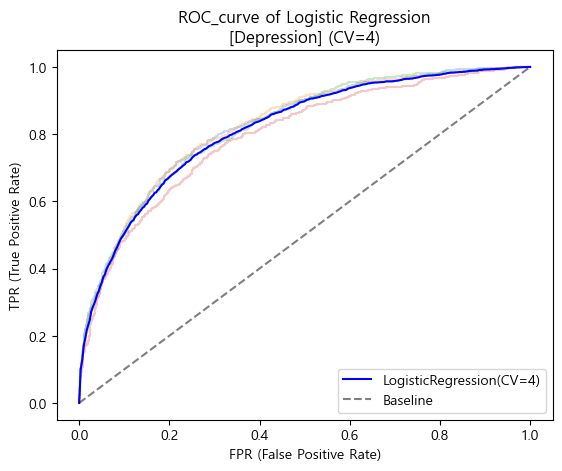

In [29]:
# ROC curve 그리기 (KFold 이용)
kf_4 = StratifiedKFold(n_splits=4, shuffle=True, random_state=2023)

# TPR(True Positive Rate) 리스트
TPRs_logistic_depr = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_logistic_depr = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Fit
    model_logistic_depr.fit(X_train_cv, y_train_cv)    
    # Predict Probability
    y_val_prob = model_logistic_depr.predict_proba(X_val_cv)[:,1]
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_depr = np.interp(x=base_FPR_logistic_depr, xp=FPR, fp=TPR)
    TPR_depr[0] = 0.0
    TPRs_logistic_depr.append(TPR_depr)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_logistic_depr = np.array(TPRs_logistic_depr)
mean_TPRs_logistic_depr = TPRs_logistic_depr.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_logistic_depr, mean_TPRs_logistic_depr,
         label='LogisticRegression(CV=4)', color='Blue')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of Logistic Regression\n[Depression] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [30]:
# ROC_AUC score 산출 (cv=4)
CV_AUC_logistic_depr = cross_val_score(estimator = model_logistic_depr,
                                       X=X_train_depr, y=y_train_depr,
                                       cv=4, n_jobs=-1, scoring='roc_auc')
print("[Depression]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_depr))
print("LogisticRegression AUC score : {:.4f}".format(CV_AUC_logistic_depr.mean()))

[Depression]
Baseline AUC score : 0.5000
LogisticRegression AUC score : 0.8161


#### 2-2. 🛠️ Cross-Validation (Depression)<br>LightGBM Classifier

- Accuracy (정확도)

In [31]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_lgbm_depr = pickle.load(open("../tuning-models/LightGBM_depr.pkl", "rb"))

# 학습 실시 (Fit)
model_lgbm_depr.fit(X_train_depr, y_train_depr)

# CV Accuracy(정확도) 산출 (cv=4)
CV_acc_lgbm_depr = cross_val_score(estimator = model_lgbm_depr,
                                       X=X_train_depr, y=y_train_depr,
                                       cv=4, n_jobs=-1, scoring='accuracy')
print("[Depression]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_depr))
print("LightGBM Accuracy : {:.4f}".format(CV_acc_lgbm_depr.mean()))

[Depression]
Baseline Accuracy : 0.7956
LightGBM Accuracy : 0.8296


- CV Prediction (교차검증 예측)

In [32]:
# CV prediction 실시
CV_pred_lgbm_depr = cross_val_predict(estimator = model_lgbm_depr,
                                      X=X_train_depr, y=y_train_depr,
                                      cv=4, n_jobs=-1)
# Table을 통해 확인해보기
df_pred_lgbm_depr = pd.DataFrame(data={'true_depr': y_train_depr,
                                       'pred_depr': CV_pred_lgbm_depr})
table_pred_lgbm_depr = pd.crosstab(df_pred_lgbm_depr['true_depr'],
                                   df_pred_lgbm_depr['pred_depr'])
display(table_pred_lgbm_depr)

pred_depr,0,1
true_depr,,
0,10127,420
1,1839,870


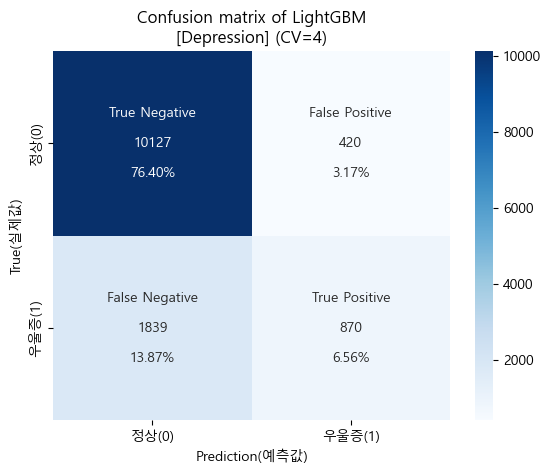

In [33]:
# Confusion matrix (혼동행렬)
cfm_lgbm_depr = confusion_matrix(y_train_depr, CV_pred_lgbm_depr)

# 시각화에 표시할 값들을 정의하기
group_names_lgbm_depr = ['True Negative','False Positive','False Negative','True Positive']
group_counts_lgbm_depr = ['{0:0.0f}'.format(value) for value in cfm_lgbm_depr.flatten()]
group_percent_lgbm_depr = ['{0:.2%}'.format(value) for value in cfm_lgbm_depr.flatten()/np.sum(cfm_lgbm_depr)]

labels_lgbm_depr = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_lgbm_depr,
                                                                group_counts_lgbm_depr,
                                                                group_percent_lgbm_depr)]
labels_lgbm_depr = np.asarray(labels_lgbm_depr).reshape(2,2)

tick_lgbm_depr = ['정상(0)', '우울증(1)']

# 시각화(heatmap)
sns.heatmap(cfm_lgbm_depr, annot=labels_lgbm_depr, fmt='', cmap='Blues',
            xticklabels=tick_lgbm_depr, yticklabels=tick_lgbm_depr)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of LightGBM\n[Depression] (CV=4)")
plt.show()

- ROC_AUC score

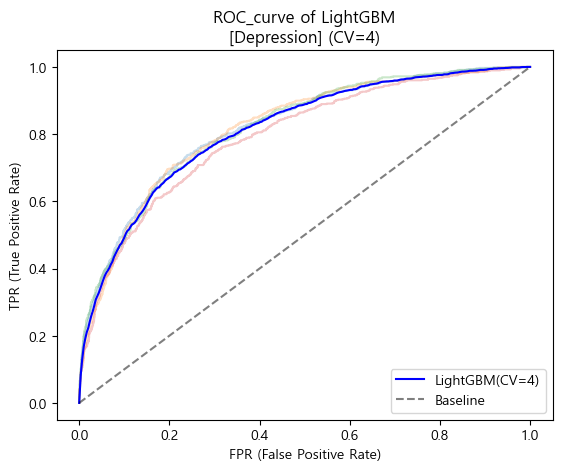

In [34]:
# TPR(True Positive Rate) 리스트
TPRs_lgbm_depr = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_lgbm_depr = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Fit
    model_lgbm_depr.fit(X_train_cv, y_train_cv)    
    # Predict Probability
    y_val_prob = model_lgbm_depr.predict_proba(X_val_cv)[:,1]
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_depr = np.interp(x=base_FPR_lgbm_depr, xp=FPR, fp=TPR)
    TPR_depr[0] = 0.0
    TPRs_lgbm_depr.append(TPR_depr)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_lgbm_depr = np.array(TPRs_lgbm_depr)
mean_TPRs_lgbm_depr = TPRs_lgbm_depr.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_lgbm_depr, mean_TPRs_lgbm_depr,
         label='LightGBM(CV=4)', color='Blue')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of LightGBM\n[Depression] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [35]:
# ROC_AUC score 산출 (cv=4)
CV_AUC_lgbm_depr = cross_val_score(estimator = model_lgbm_depr,
                                       X=X_train_depr, y=y_train_depr,
                                       cv=4, n_jobs=-1, scoring='roc_auc')
print("[Depression]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_depr))
print("LightGBM AUC score : {:.4f}".format(CV_AUC_lgbm_depr.mean()))

[Depression]
Baseline AUC score : 0.5000
LightGBM AUC score : 0.8154


#### 2-3. 🛠️ Cross-Validation (Depression)<br>DeepLearning - MLP(Multi Layer Perceptron)

- Accuracy (정확도)

In [36]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_mlp_depr = load_model('../tuning-models/MLP_depr.h5')

# Accuracy score를 담을 리스트를 생성
mlp_val_acc_cv = []

# KFold로 Accuracy Score 산출
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_depr.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # Accuracy score 연산, 리스트에 append
    mlp_val_acc = accuracy_score(y_val_cv, y_val_pred)
    mlp_val_acc_cv.append(mlp_val_acc)

# 평균 Accuracy score 연산
CV_acc_mlp_depr = np.array(mlp_val_acc_cv).mean()

print("[Depression]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_depr))
print("DL_MLP Accuracy : {:.4f}".format(CV_acc_mlp_depr.mean()))

[Depression]
Baseline Accuracy : 0.7956
DL_MLP Accuracy : 0.8324


- CV Prediction (교차검증 예측)

In [40]:
# cv마다 true value와 predict value를 append하는 방식으로 cross_val_predict를 구현해본다
# KFold를 통해 shuffle이 이루어지기 때문에 true값에 대한 array도 함께 정의
mlp_val_true_cv = np.array([], dtype=int)
mlp_val_pred_cv = np.array([], dtype=int)

# KFold 수행
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_depr.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # true값(Series)를 array로 변환
    y_val_true = np.array(y_val_cv)
    
    # true값과 pred값을 append
    mlp_val_true_cv = np.append(mlp_val_true_cv, y_val_true)
    mlp_val_pred_cv = np.append(mlp_val_pred_cv, y_val_pred)

# Table을 통해 확인해보기
df_pred_mlp_depr = pd.DataFrame(data={'true_depr': mlp_val_true_cv,
                                      'pred_depr': mlp_val_pred_cv})
table_pred_mlp_depr = pd.crosstab(df_pred_mlp_depr['true_depr'],
                                  df_pred_mlp_depr['pred_depr'])
display(table_pred_mlp_depr)

pred_depr,0,1
true_depr,,
0,10053,494
1,1728,981


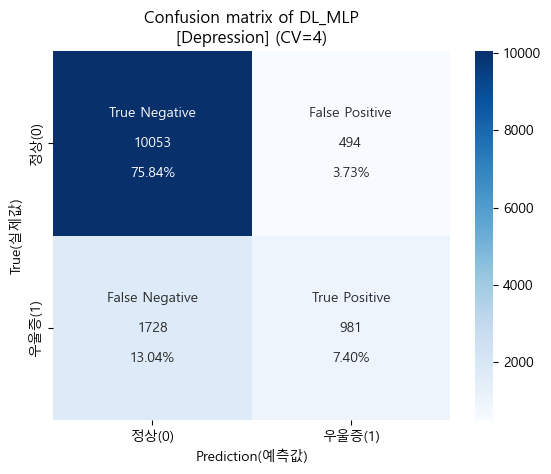

In [41]:
# Confusion matrix (혼동행렬)
cfm_mlp_depr = confusion_matrix(mlp_val_true_cv, mlp_val_pred_cv)

# 시각화에 표시할 값들을 정의하기
group_names_mlp_depr = ['True Negative','False Positive','False Negative','True Positive']
group_counts_mlp_depr = ['{0:0.0f}'.format(value) for value in cfm_mlp_depr.flatten()]
group_percent_mlp_depr = ['{0:.2%}'.format(value) for value in cfm_mlp_depr.flatten()/np.sum(cfm_mlp_depr)]

labels_mlp_depr = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_mlp_depr,
                                                                group_counts_mlp_depr,
                                                                group_percent_mlp_depr)]
labels_mlp_depr = np.asarray(labels_mlp_depr).reshape(2,2)

tick_mlp_depr = ['정상(0)', '우울증(1)']

# 시각화(heatmap)
sns.heatmap(cfm_mlp_depr, annot=labels_mlp_depr, fmt='', cmap='Blues',
            xticklabels=tick_mlp_depr, yticklabels=tick_mlp_depr)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of DL_MLP\n[Depression] (CV=4)")
plt.show()

- ROC_AUC score

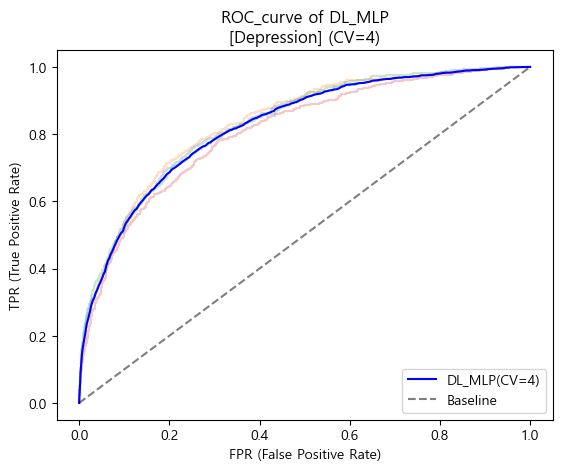

In [42]:
# TPR(True Positive Rate) 리스트
TPRs_mlp_depr = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_mlp_depr = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_depr.predict(X_val_cv, verbose=0).flatten()
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_depr = np.interp(x=base_FPR_mlp_depr, xp=FPR, fp=TPR)
    TPR_depr[0] = 0.0
    TPRs_mlp_depr.append(TPR_depr)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_mlp_depr = np.array(TPRs_mlp_depr)
mean_TPRs_mlp_depr = TPRs_mlp_depr.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_mlp_depr, mean_TPRs_mlp_depr,
         label='DL_MLP(CV=4)', color='Blue')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of DL_MLP\n[Depression] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [49]:
# ROC_AUC score 산출 (cv=4)
# AUC score를 담을 리스트를 생성
mlp_val_AUC_cv = []

# KFold로 AUC score 산출
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_depr.predict(X_val_cv, verbose=0).flatten()
    
    # AUC score 연산, 리스트에 append
    mlp_val_AUC = roc_auc_score(y_val_cv, y_val_prob)
    mlp_val_AUC_cv.append(mlp_val_AUC)

# 평균 AUC score 연산
CV_AUC_mlp_depr = np.array(mlp_val_AUC_cv).mean()

print("[Depression]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_depr))
print("DL_MLP AUC score : {:.4f}".format(CV_AUC_mlp_depr.mean()))

[Depression]
Baseline AUC score : 0.5000
DL_MLP AUC score : 0.8249


#### 2-4. 🛠️ Cross-Validation (Depression)<br>DeepLearning - 1D-CNN (Convolutional Neural Networks)

- Accuracy (정확도)

In [50]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_cnn_depr = load_model('../tuning-models/CNN_depr.h5')

# Accuracy score를 담을 리스트를 생성
cnn_val_acc_cv = []

# KFold로 Accuracy Score 산출
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_depr.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # Accuracy score 연산, 리스트에 append
    cnn_val_acc = accuracy_score(y_val_cv, y_val_pred)
    cnn_val_acc_cv.append(cnn_val_acc)

# 평균 Accuracy score 연산
CV_acc_cnn_depr = np.array(cnn_val_acc_cv).mean()

print("[Depression]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_depr))
print("DL_1D-CNN Accuracy : {:.4f}".format(CV_acc_cnn_depr.mean()))

[Depression]
Baseline Accuracy : 0.7956
DL_1D-CNN Accuracy : 0.8366


- CV Prediction (교차검증 예측)

In [51]:
# MLP와 동일한 방식으로 진행한다
cnn_val_true_cv = np.array([], dtype=int)
cnn_val_pred_cv = np.array([], dtype=int)

# KFold 수행
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_depr.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # true값(Series)를 array로 변환
    y_val_true = np.array(y_val_cv)
    
    # true값과 pred값을 append
    cnn_val_true_cv = np.append(cnn_val_true_cv, y_val_true)
    cnn_val_pred_cv = np.append(cnn_val_pred_cv, y_val_pred)

# Table을 통해 확인해보기
df_pred_cnn_depr = pd.DataFrame(data={'true_depr': cnn_val_true_cv,
                                      'pred_depr': cnn_val_pred_cv})
table_pred_cnn_depr = pd.crosstab(df_pred_cnn_depr['true_depr'],
                                  df_pred_cnn_depr['pred_depr'])
display(table_pred_cnn_depr)

pred_depr,0,1
true_depr,,
0,10115,432
1,1734,975


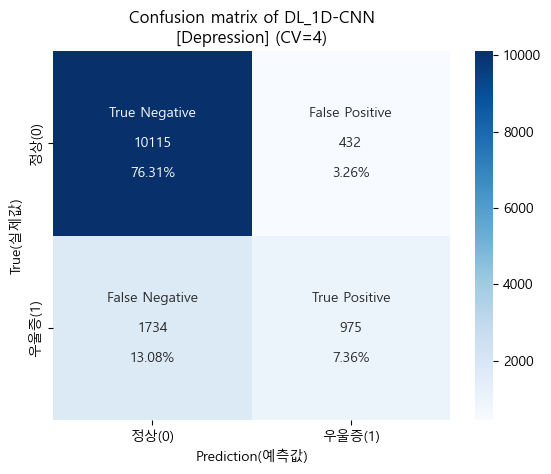

In [52]:
# Confusion matrix (혼동행렬)
cfm_cnn_depr = confusion_matrix(cnn_val_true_cv, cnn_val_pred_cv)

# 시각화에 표시할 값들을 정의하기
group_names_cnn_depr = ['True Negative','False Positive','False Negative','True Positive']
group_counts_cnn_depr = ['{0:0.0f}'.format(value) for value in cfm_cnn_depr.flatten()]
group_percent_cnn_depr = ['{0:.2%}'.format(value) for value in cfm_cnn_depr.flatten()/np.sum(cfm_cnn_depr)]

labels_cnn_depr = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_cnn_depr,
                                                                group_counts_cnn_depr,
                                                                group_percent_cnn_depr)]
labels_cnn_depr = np.asarray(labels_cnn_depr).reshape(2,2)

tick_cnn_depr = ['정상(0)', '우울증(1)']

# 시각화(heatmap)
sns.heatmap(cfm_cnn_depr, annot=labels_cnn_depr, fmt='', cmap='Blues',
            xticklabels=tick_cnn_depr, yticklabels=tick_cnn_depr)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of DL_1D-CNN\n[Depression] (CV=4)")
plt.show()

- ROC_AUC score

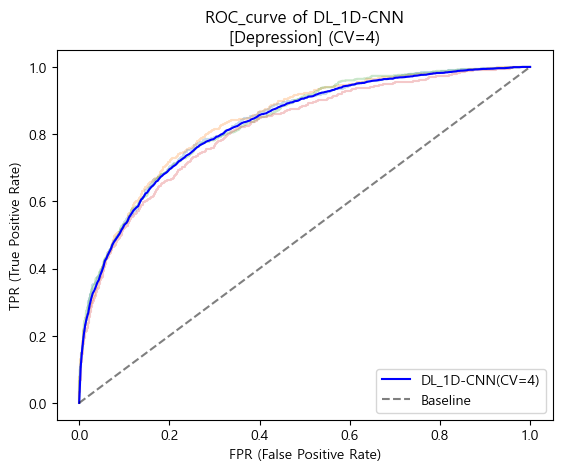

In [53]:
# TPR(True Positive Rate) 리스트
TPRs_cnn_depr = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_cnn_depr = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_depr.predict(X_val_cv, verbose=0).flatten()
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_depr = np.interp(x=base_FPR_cnn_depr, xp=FPR, fp=TPR)
    TPR_depr[0] = 0.0
    TPRs_cnn_depr.append(TPR_depr)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_cnn_depr = np.array(TPRs_cnn_depr)
mean_TPRs_cnn_depr = TPRs_cnn_depr.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_cnn_depr, mean_TPRs_cnn_depr,
         label='DL_1D-CNN(CV=4)', color='Blue')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of DL_1D-CNN\n[Depression] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [54]:
# ROC_AUC score 산출 (cv=4)
# AUC score를 담을 리스트를 생성
cnn_val_AUC_cv = []

# KFold로 AUC score 산출
for train_idx, val_idx in kf_4.split(X_train_depr, y_train_depr):
    X_train_cv, X_val_cv = X_train_depr.iloc[train_idx], X_train_depr.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_depr.iloc[train_idx], y_train_depr.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_depr.predict(X_val_cv, verbose=0).flatten()
    
    # AUC score 연산, 리스트에 append
    cnn_val_AUC = roc_auc_score(y_val_cv, y_val_prob)
    cnn_val_AUC_cv.append(cnn_val_AUC)

# 평균 AUC score 연산
CV_AUC_cnn_depr = np.array(cnn_val_AUC_cv).mean()

print("[Depression]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_depr))
print("DL_1D-CNN AUC score : {:.4f}".format(CV_AUC_cnn_depr.mean()))

[Depression]
Baseline AUC score : 0.5000
DL_1D-CNN AUC score : 0.8291


#### 3-1. 📊 Compare Models Performance (모델 성능 비교분석)

- Accuracy & AUC score 비교 데이터 생성

In [56]:
# 성능 비교를 위한 DataFrame 정의
df_score_depr = pd.DataFrame({'Accuracy':[baseline_acc_depr,
                                          CV_acc_logistic_depr.mean(),
                                          CV_acc_lgbm_depr.mean(),
                                          CV_acc_mlp_depr,
                                          CV_acc_cnn_depr],
                              'AUC_score':[baseline_AUC_depr,
                                           CV_AUC_logistic_depr.mean(),
                                           CV_AUC_lgbm_depr.mean(),
                                           CV_AUC_mlp_depr,
                                           CV_AUC_cnn_depr]},
                             index=['Baseline', 'Logistic', 'LightGBM', 'DL_MLP', 'DL_1D-CNN'])\
                            .sort_values(by='AUC_score',ascending=True)
display(df_score_depr)

,Accuracy,AUC_score
Baseline,0.795640,0.500000
LightGBM,0.829587,0.815389
Logistic,0.829964,0.816094
DL_MLP,0.832378,0.824885
DL_1D-CNN,0.836602,0.829079


- 평가지표 시각화 (bar-plot)

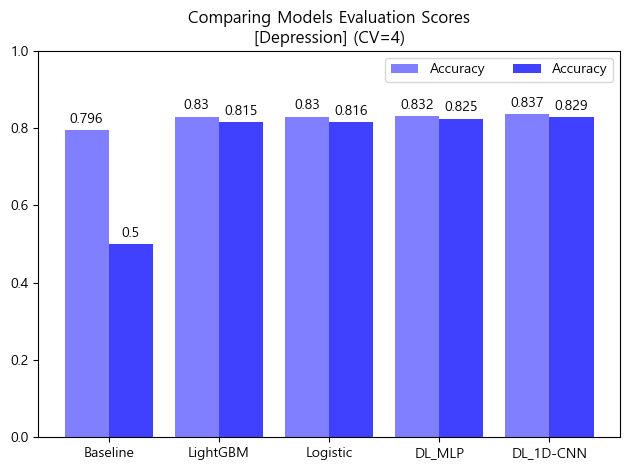

In [59]:
# 검증 스코어 시각화
x_depr = np.arange(len(df_score_depr))
width_depr = 0.4

# subplot 정의
fig_depr, ax_depr = plt.subplots()
# Accuracy bar
rect1 = ax_depr.bar(x= x_depr - width_depr/2,
                    height=df_score_depr.Accuracy.round(3),
                    width=width_depr,
                    label='Accuracy',
                    color='Blue', alpha=0.5)
# AUC score bar
rect2 = ax_depr.bar(x= x_depr + width_depr/2,
                    height=df_score_depr.AUC_score.round(3),
                    width=width_depr,
                    label='Accuracy',
                    color='Blue', alpha=0.75)

# plot 설정
ax_depr.set_title("Comparing Models Evaluation Scores\n[Depression] (CV=4)")
ax_depr.set_xticks(x_depr, df_score_depr.index)
ax_depr.bar_label(rect1, padding=3)
ax_depr.bar_label(rect2, padding=3)
fig_depr.tight_layout()
plt.ylim([0,1])
plt.legend(ncol=2)
plt.show()

- ROC curves 시각화

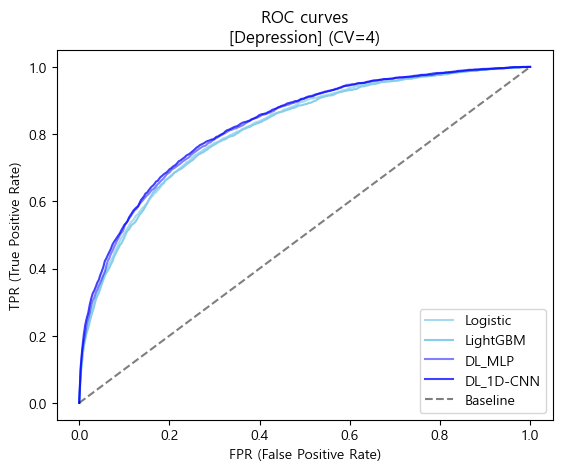

In [60]:
# CV 평균 ROC curve를 비교하기 위한 시각화
plt.plot(base_FPR_logistic_depr, mean_TPRs_logistic_depr,
         label='Logistic', color='skyblue', alpha=0.75)
plt.plot(base_FPR_lgbm_depr, mean_TPRs_lgbm_depr,
         label='LightGBM', color='skyblue', alpha=1)
plt.plot(base_FPR_mlp_depr, mean_TPRs_mlp_depr,
         label='DL_MLP', color='blue', alpha=0.5)
plt.plot(base_FPR_cnn_depr, mean_TPRs_cnn_depr,
         label='DL_1D-CNN', color='blue', alpha=0.75)
plt.plot([0,1],[0,1], label='Baseline', linestyle='--', color='black', alpha=0.5)
plt.title('ROC curves\n[Depression] (CV=4)')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.legend(loc='lower right')
plt.show()

#### 3-2. 🏆 Final Model Selection (최종 모델 선정)
- 모델들 모두 Baseline에 비해선 Accuracy score와 AUC score가 높게 나타남
- 모델들 중에선 Accuracy score와 AUC score 모두 1D-CNN 모델이 가장 높은 성능을 나타냈음

- 🏆 따라서 Depression(정상vs우울증)에서는 "1D-CNN 모델"을 최종 모델로 선정

#### 3-3. 📝 Final Model Test (최종 모델 테스트)
- 학습에 이용되지 않았던 Test Dataset을 통해 일반화 가능성을 최종적으로 검증

In [63]:
# Test Data Prediction
y_test_prob = model_cnn_depr.predict(X_test_depr, verbose=0).flatten()
y_test_pred = np.where(y_test_prob<0.5, 0, 1)

# Table을 통해 확인해보기
df_test_depr = pd.DataFrame(data={'true_depr': y_test_depr,
                                   'pred_depr': y_test_pred})
table_test_depr = pd.crosstab(df_test_depr['true_depr'],
                              df_test_depr['pred_depr'])
display(table_test_depr)

pred_depr,0,1
true_depr,,
0,2536,128
1,418,232


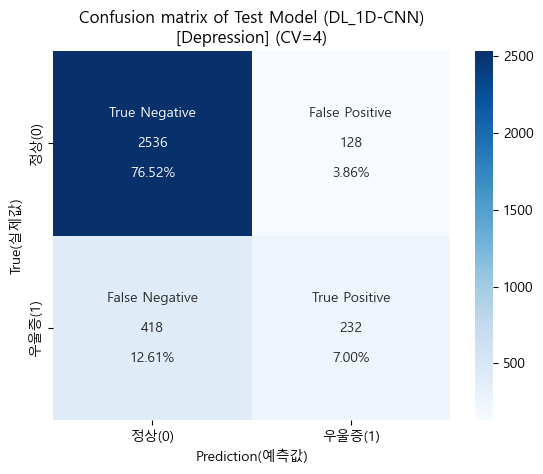

In [64]:
# Confusion matrix (혼동행렬)
cfm_test_depr = confusion_matrix(y_test_depr, y_test_pred)

# 시각화에 표시할 값들을 정의하기
group_names_test_depr = ['True Negative','False Positive','False Negative','True Positive']
group_counts_test_depr = ['{0:0.0f}'.format(value) for value in cfm_test_depr.flatten()]
group_percent_test_depr = ['{0:.2%}'.format(value) for value in cfm_test_depr.flatten()/np.sum(cfm_test_depr)]

labels_test_depr = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_test_depr,
                                                                group_counts_test_depr,
                                                                group_percent_test_depr)]
labels_test_depr = np.asarray(labels_test_depr).reshape(2,2)

tick_test_depr = ['정상(0)', '우울증(1)']

# 시각화(heatmap)
sns.heatmap(cfm_test_depr, annot=labels_test_depr, fmt='', cmap='Blues',
            xticklabels=tick_test_depr, yticklabels=tick_test_depr)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of Test Model (DL_1D-CNN)\n[Depression] (CV=4)")
plt.show()

In [65]:
# Test Model Accuracy Score
score_acc_test_depr = accuracy_score(y_test_depr, y_test_pred)
print("[Depression]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_depr))
print("Validation Accuracy (cv=4) : {:.4f}".format(CV_acc_cnn_depr))
print("Test Accuracy : {:.4f}".format(score_acc_test_depr))

[Depression]
Baseline Accuracy : 0.7956
Validation Accuracy (cv=4) : 0.8366
Test Accuracy : 0.8352


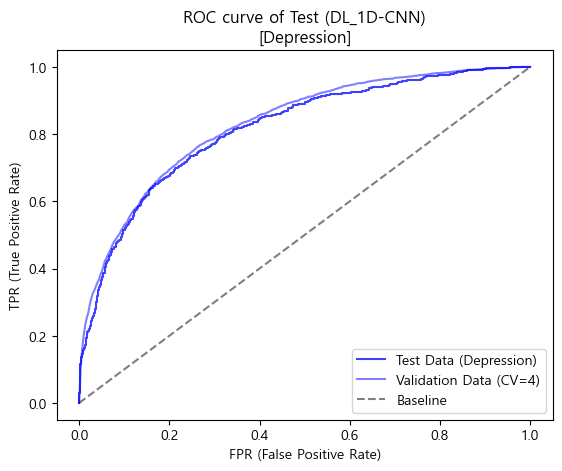

In [66]:
# ROC curve 시각화
FPR_test_depr, TPR_test_depr, _ = roc_curve(y_test_depr, y_test_prob)
plt.plot(FPR_test_depr, TPR_test_depr,
         label='Test Data (Depression)', color='blue', alpha=0.75)
plt.plot(base_FPR_cnn_depr, mean_TPRs_cnn_depr,
         label='Validation Data (CV=4)', color='blue', alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--',
         label='Baseline', color='black', alpha=0.5)
plt.title("ROC curve of Test (DL_1D-CNN)\n[Depression]")
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.legend(loc='lower right')
plt.show()

In [67]:
# Test Model AUC Score
score_AUC_test_depr = roc_auc_score(y_test_depr, y_test_prob)
print("[Depression]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_depr))
print("Validation AUC score (cv=4) : {:.4f}".format(CV_AUC_cnn_depr))
print("Test AUC score : {:.4f}".format(score_AUC_test_depr))

[Depression]
Baseline AUC score : 0.5000
Validation AUC score (cv=4) : 0.8291
Test AUC score : 0.8156


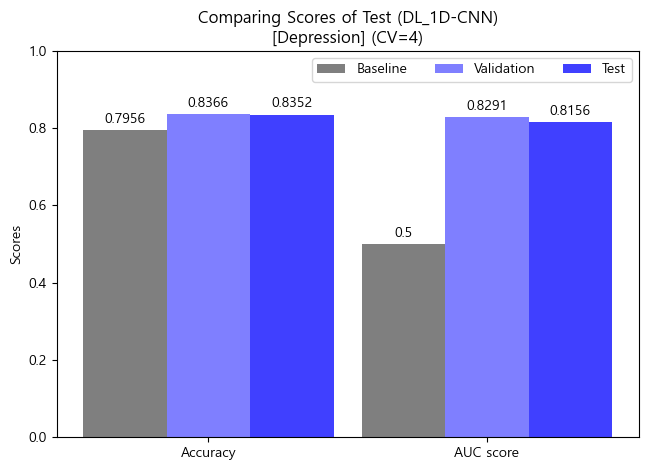

In [68]:
# Test Model 평가지표 시각화 (bar-plot)
df_test_cnn_depr = pd.DataFrame({'Baseline':[baseline_acc_depr,
                                             baseline_AUC_depr],
                                 'Validation':[CV_acc_cnn_depr,
                                               CV_AUC_cnn_depr],
                                 'Test':[score_acc_test_depr,
                                         score_AUC_test_depr]},
                                index=['Accuracy', 'AUC score'])
x_cnn_depr = np.arange(len(df_test_cnn_depr))
width_cnn_depr = 0.3

# subplot 정의
fig_cnn_depr, ax_cnn_depr = plt.subplots()
# Baseline bar
rect1 = ax_cnn_depr.bar(x= x_cnn_depr - width_cnn_depr,
                        height=df_test_cnn_depr.Baseline.round(4),
                        width=width_cnn_depr,
                        label='Baseline',
                        color='black', alpha=0.5)
# Validation bar
rect2 = ax_cnn_depr.bar(x= x_cnn_depr,
                        height=df_test_cnn_depr.Validation.round(4),
                        width=width_cnn_depr,
                        label='Validation',
                        color='blue', alpha=0.5)
# Test bar
rect3 = ax_cnn_depr.bar(x= x_cnn_depr + width_cnn_depr,
                        height=df_test_cnn_depr.Test.round(4),
                        width=width_cnn_depr,
                        label='Test',
                        color='blue', alpha=0.75)

# plot 설정
ax_cnn_depr.set_title("Comparing Scores of Test (DL_1D-CNN)\n[Depression] (CV=4)")
ax_cnn_depr.set_xticks(x_cnn_depr, df_test_cnn_depr.index)
ax_cnn_depr.bar_label(rect1, padding=3)
ax_cnn_depr.bar_label(rect2, padding=3)
ax_cnn_depr.bar_label(rect3, padding=3)
fig_cnn_depr.tight_layout()
plt.ylabel("Scores")
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

💡 Final Model Test 일반화 가능성
- Depression(정상vs우울증)의 최종 모델인 1D-CNN 모델에 대하여 테스트 데이터셋으로 일반화 가능성을 최종적으로 검증하였음
- 테스트 결과, Validation 및 Test 데이터의 Accuracy와 AUC score 모두 비슷하게 나타났으며, 이에따라 일반화 가능성도 높은 모델이라 판단해 볼 수 있었음.
---

### 🧠 Major Depressive Disorder (경도우울증 vs 주요우울장애)
- 진행방식은 Depression과 동일하게 진행할 것임.

#### 1-1. 💾 데이터 불러오기

In [106]:
# 전처리를 마친 데이터를 불러오기
df_mdd = pd.read_csv("./downloads/Encoded_mdd.csv")
print(f"MDD Dataset Shape : {df_mdd.shape}")

MDD Dataset Shape : (3359, 48)


#### 1-2. ⚙️ Feature, Target 분리

In [107]:
# Feature, Target 분리
features_mdd = df_mdd.drop(columns='MDD')
target_mdd = df_mdd['MDD']
# Shape 확인
print(f"분리 전 Shape : {df_mdd.shape}")
print(f"\n분리 후 Shape : {features_mdd.shape}, {target_mdd.shape}")

분리 전 Shape : (3359, 48)

분리 후 Shape : (3359, 47), (3359,)


#### 1-3. 📊 Target 분포 확인

In [108]:
# Target 수 확인
count_mdd = target_mdd.value_counts().sort_index()
print("Target(MDD) 수")
print(count_mdd)
# Target 비율 확인
ratio_mdd = target_mdd.value_counts(normalize=True).sort_index()
print("\nTarget(MDD) 비율")
print(ratio_mdd)

Target(MDD) 수
0    2443
1     916
Name: MDD, dtype: int64

Target(MDD) 비율
0    0.7273
1    0.2727
Name: MDD, dtype: float64


Target(MDD) 수
0    2443
1     916
Name: MDD, dtype: int64


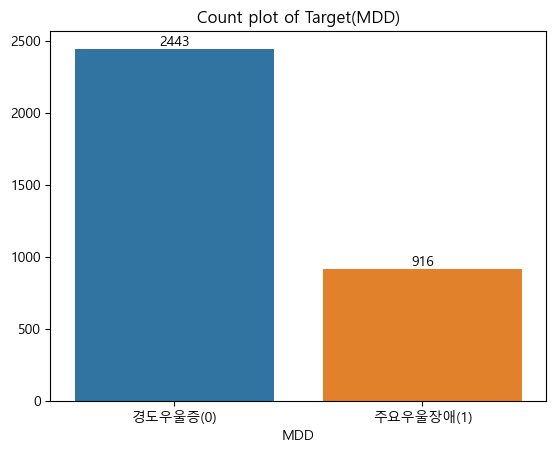

In [109]:
# label 정의
label_mdd = ['경도우울증(0)', '주요우울장애(1)']
# Target 수
print("Target(MDD) 수")
print(count_mdd)
# 시각화 (빈도)
ax_bar_mdd = sns.countplot(x=target_mdd)
ax_bar_mdd.bar_label(ax_bar_mdd.containers[0])
plt.xticks([0,1], label_mdd)
plt.title("Count plot of Target(MDD)")
plt.xlabel("MDD")
plt.ylabel("")
plt.show()


Target(MDD) 비율
0    0.7273
1    0.2727
Name: MDD, dtype: float64


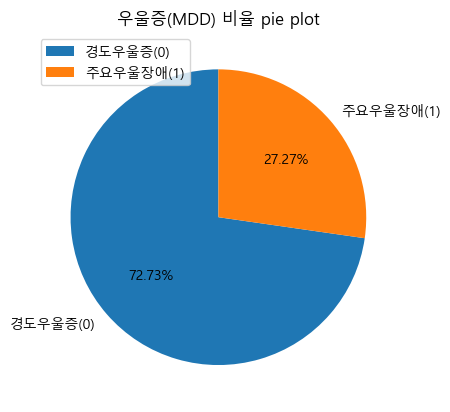

In [110]:
# Target 비율
print("\nTarget(MDD) 비율")
print(ratio_mdd)
# 시각화 (비율)
plt.pie(x = count_mdd, labels=label_mdd, autopct='%.2f%%', startangle=90)
plt.legend(loc = 'upper left')
plt.title('우울증(MDD) 비율 pie plot')
plt.show()

#### 1-4. 🔎 Feature 분포 확인

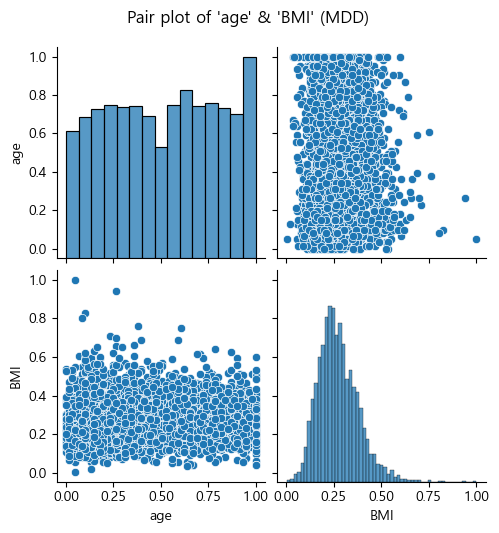

In [111]:
# 수치형변수(age, BMI) 분포, 상관관계 시각화
num_feat = ['age', 'BMI']
sns.pairplot(features_mdd[num_feat])
plt.suptitle("Pair plot of 'age' & 'BMI' (MDD)", y=1.05)
plt.show()

In [112]:
# Feature Column 표준화 여부 확인 (min, max 값 확인)
print(f"Feature Min Value : {features_mdd.min().min()}")
print(f"Feature Max Value : {features_mdd.max().max()}")

Feature Min Value : 0.0
Feature Max Value : 1.0


#### 1-5. ⚙️ Train, Test 데이터 분리

In [113]:
# Train, Test 분리 (test 비율 20%, seed=2023)
X_train_mdd, X_test_mdd, y_train_mdd, y_test_mdd = train_test_split(
    features_mdd, target_mdd, test_size=0.2, random_state=2023)

print('X_train_mdd : {}'.format(X_train_mdd.shape))
print('y_train_mdd : {}'.format(y_train_mdd.shape))
print('\nX_test_mdd : {}'.format(X_test_mdd.shape))
print('y_test_mdd : {}'.format(y_test_mdd.shape))

X_train_mdd : (2687, 47)
y_train_mdd : (2687,)

X_test_mdd : (672, 47)
y_test_mdd : (672,)


In [114]:
# Train, Test의 Target 데이터 비율 확인
print("MDD - Train")
print(y_train_mdd.value_counts(normalize=True))
print("\nMDD - Test")
print(y_test_mdd.value_counts(normalize=True))

MDD - Train
0    0.727577
1    0.272423
Name: MDD, dtype: float64

MDD - Test
0    0.72619
1    0.27381
Name: MDD, dtype: float64


#### 1-6. ⚙️ Baseline Model 정의 (최빈 Class 비율)

In [115]:
# 최빈값 지정 및 Baseline 모델 정의
mode_mdd = y_train_mdd.mode()[0]
baseline_mdd = [mode_mdd]*len(y_train_mdd)
# Baseline Accuracy & ROC_AUCscore 산출
baseline_acc_mdd = accuracy_score(y_train_mdd, baseline_mdd)
baseline_AUC_mdd = roc_auc_score(y_train_mdd, baseline_mdd)
print("[MDD]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_mdd))
print("Baseline AUC_score : {}".format(baseline_AUC_mdd))

[MDD]
Baseline Accuracy : 0.7276
Baseline AUC_score : 0.5


#### 2-1. 🛠️ Cross-Validation (Depression)<br>Logistic Regression

- Accuracy (정확도)

In [116]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_logistic_mdd = pickle.load(open("../tuning-models/Logistic_mdd.pkl", "rb"))

# 학습 실시 (Fit)
model_logistic_mdd.fit(X_train_mdd, y_train_mdd)

# CV Accuracy(정확도) 산출 (cv=4)
CV_acc_logistic_mdd = cross_val_score(estimator = model_logistic_mdd,
                                      X=X_train_mdd, y=y_train_mdd,
                                      cv=4, n_jobs=-1, scoring='accuracy')
print("[MDD]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_mdd))
print("LogisticRegression Accuracy : {:.4f}".format(CV_acc_logistic_mdd.mean()))

[MDD]
Baseline Accuracy : 0.7276
LogisticRegression Accuracy : 0.7659


- CV Prediction (교차검증 예측)

In [117]:
# CV prediction 실시
CV_pred_logistic_mdd = cross_val_predict(estimator = model_logistic_mdd,
                                         X=X_train_mdd, y=y_train_mdd,
                                         cv=4, n_jobs=-1)
# Table을 통해 확인해보기
df_pred_logistic_mdd = pd.DataFrame(data={'true_mdd': y_train_mdd,
                                          'pred_mdd': CV_pred_logistic_mdd})
table_pred_logistic_mdd = pd.crosstab(df_pred_logistic_mdd['true_mdd'],
                                      df_pred_logistic_mdd['pred_mdd'])
display(table_pred_logistic_mdd)

pred_mdd,0,1
true_mdd,,
0,1862,93
1,536,196


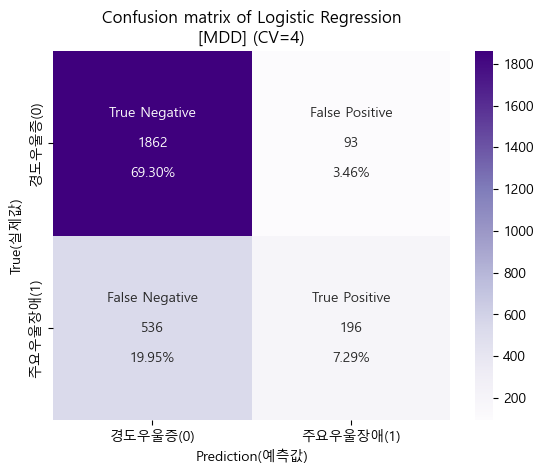

In [118]:
# Confusion matrix (혼동행렬)
cfm_logistic_mdd = confusion_matrix(y_train_mdd, CV_pred_logistic_mdd)

# 시각화에 표시할 값들을 정의하기
group_names_logistic_mdd = ['True Negative','False Positive','False Negative','True Positive']
group_counts_logistic_mdd = ['{0:0.0f}'.format(value) for value in cfm_logistic_mdd.flatten()]
group_percent_logistic_mdd = ['{0:.2%}'.format(value) for value in cfm_logistic_mdd.flatten()/np.sum(cfm_logistic_mdd)]

labels_logistic_mdd = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_logistic_mdd,
                                                                    group_counts_logistic_mdd,
                                                                    group_percent_logistic_mdd)]
labels_logistic_mdd = np.asarray(labels_logistic_mdd).reshape(2,2)

tick_logistic_mdd = ['경도우울증(0)', '주요우울장애(1)']

# 시각화(heatmap)
sns.heatmap(cfm_logistic_mdd, annot=labels_logistic_mdd, fmt='', cmap='Purples',
            xticklabels=tick_logistic_mdd, yticklabels=tick_logistic_mdd)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of Logistic Regression\n[MDD] (CV=4)")
plt.show()

- ROC_AUC score

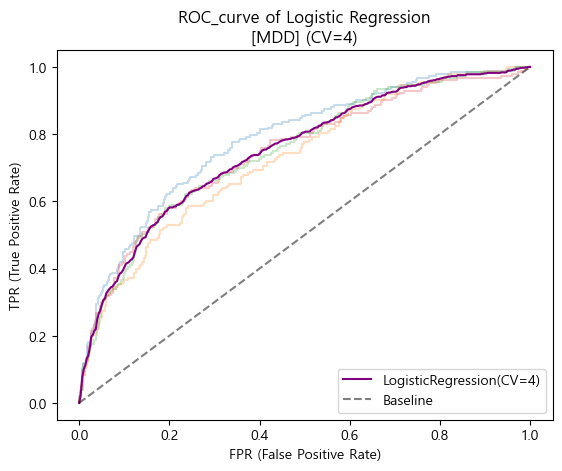

In [119]:
# ROC curve 그리기 (KFold 이용)
kf_4 = StratifiedKFold(n_splits=4, shuffle=True, random_state=2023)

# TPR(True Positive Rate) 리스트
TPRs_logistic_mdd = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_logistic_mdd = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Fit
    model_logistic_mdd.fit(X_train_cv, y_train_cv)    
    # Predict Probability
    y_val_prob = model_logistic_mdd.predict_proba(X_val_cv)[:,1]
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_mdd = np.interp(x=base_FPR_logistic_mdd, xp=FPR, fp=TPR)
    TPR_mdd[0] = 0.0
    TPRs_logistic_mdd.append(TPR_mdd)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_logistic_mdd = np.array(TPRs_logistic_mdd)
mean_TPRs_logistic_mdd = TPRs_logistic_mdd.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_logistic_mdd, mean_TPRs_logistic_mdd,
         label='LogisticRegression(CV=4)', color='purple')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of Logistic Regression\n[MDD] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [120]:
# ROC_AUC score 산출 (cv=4)
CV_AUC_logistic_mdd = cross_val_score(estimator = model_logistic_mdd,
                                       X=X_train_mdd, y=y_train_mdd,
                                       cv=4, n_jobs=-1, scoring='roc_auc')
print("[MDD]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_mdd))
print("LogisticRegression AUC score : {:.4f}".format(CV_AUC_logistic_mdd.mean()))

[MDD]
Baseline AUC score : 0.5000
LogisticRegression AUC score : 0.7500


#### 2-2. 🛠️ Cross-Validation (Depression)<br>LightGBM Classifier

- Accuracy (정확도)

In [121]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_lgbm_mdd = pickle.load(open("../tuning-models/LightGBM_mdd.pkl", "rb"))

# 학습 실시 (Fit)
model_lgbm_mdd.fit(X_train_mdd, y_train_mdd)

# CV Accuracy(정확도) 산출 (cv=4)
CV_acc_lgbm_mdd = cross_val_score(estimator = model_lgbm_mdd,
                                       X=X_train_mdd, y=y_train_mdd,
                                       cv=4, n_jobs=-1, scoring='accuracy')
print("[MDD]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_mdd))
print("LightGBM Accuracy : {:.4f}".format(CV_acc_lgbm_mdd.mean()))

[MDD]
Baseline Accuracy : 0.7276
LightGBM Accuracy : 0.7573


- CV Prediction (교차검증 예측)

In [122]:
# CV prediction 실시
CV_pred_lgbm_mdd = cross_val_predict(estimator = model_lgbm_mdd,
                                      X=X_train_mdd, y=y_train_mdd,
                                      cv=4, n_jobs=-1)
# Table을 통해 확인해보기
df_pred_lgbm_mdd = pd.DataFrame(data={'true_mdd': y_train_mdd,
                                       'pred_mdd': CV_pred_lgbm_mdd})
table_pred_lgbm_mdd = pd.crosstab(df_pred_lgbm_mdd['true_mdd'],
                                   df_pred_lgbm_mdd['pred_mdd'])
display(table_pred_lgbm_mdd)

pred_mdd,0,1
true_mdd,,
0,1848,107
1,545,187


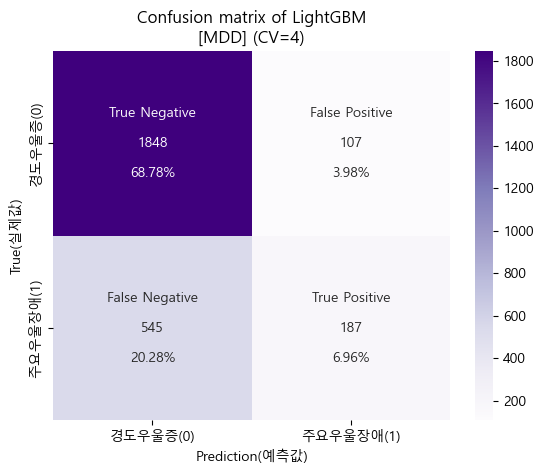

In [123]:
# Confusion matrix (혼동행렬)
cfm_lgbm_mdd = confusion_matrix(y_train_mdd, CV_pred_lgbm_mdd)

# 시각화에 표시할 값들을 정의하기
group_names_lgbm_mdd = ['True Negative','False Positive','False Negative','True Positive']
group_counts_lgbm_mdd = ['{0:0.0f}'.format(value) for value in cfm_lgbm_mdd.flatten()]
group_percent_lgbm_mdd = ['{0:.2%}'.format(value) for value in cfm_lgbm_mdd.flatten()/np.sum(cfm_lgbm_mdd)]

labels_lgbm_mdd = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_lgbm_mdd,
                                                                group_counts_lgbm_mdd,
                                                                group_percent_lgbm_mdd)]
labels_lgbm_mdd = np.asarray(labels_lgbm_mdd).reshape(2,2)

tick_lgbm_mdd = ['경도우울증(0)', '주요우울장애(1)']

# 시각화(heatmap)
sns.heatmap(cfm_lgbm_mdd, annot=labels_lgbm_mdd, fmt='', cmap='Purples',
            xticklabels=tick_lgbm_mdd, yticklabels=tick_lgbm_mdd)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of LightGBM\n[MDD] (CV=4)")
plt.show()

- ROC_AUC score

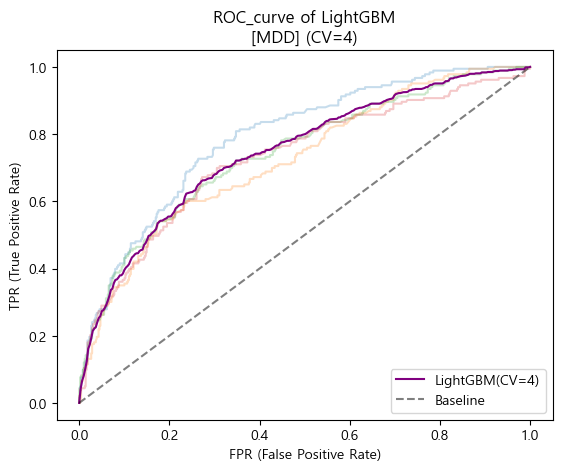

In [124]:
# TPR(True Positive Rate) 리스트
TPRs_lgbm_mdd = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_lgbm_mdd = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Fit
    model_lgbm_mdd.fit(X_train_cv, y_train_cv)    
    # Predict Probability
    y_val_prob = model_lgbm_mdd.predict_proba(X_val_cv)[:,1]
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_mdd = np.interp(x=base_FPR_lgbm_mdd, xp=FPR, fp=TPR)
    TPR_mdd[0] = 0.0
    TPRs_lgbm_mdd.append(TPR_mdd)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_lgbm_mdd = np.array(TPRs_lgbm_mdd)
mean_TPRs_lgbm_mdd = TPRs_lgbm_mdd.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_lgbm_mdd, mean_TPRs_lgbm_mdd,
         label='LightGBM(CV=4)', color='purple')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of LightGBM\n[MDD] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [125]:
# ROC_AUC score 산출 (cv=4)
CV_AUC_lgbm_mdd = cross_val_score(estimator = model_lgbm_mdd,
                                       X=X_train_mdd, y=y_train_mdd,
                                       cv=4, n_jobs=-1, scoring='roc_auc')
print("[MDD]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_mdd))
print("LightGBM AUC score : {:.4f}".format(CV_AUC_lgbm_mdd.mean()))

[MDD]
Baseline AUC score : 0.5000
LightGBM AUC score : 0.7400


#### 2-3. 🛠️ Cross-Validation (Depression)<br>DeepLearning - MLP(Multi Layer Perceptron)

- Accuracy (정확도)

In [126]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_mlp_mdd = load_model('../tuning-models/MLP_mdd.h5')

# Accuracy score를 담을 리스트를 생성
mlp_val_acc_cv = []

# KFold로 Accuracy Score 산출
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_mdd.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # Accuracy score 연산, 리스트에 append
    mlp_val_acc = accuracy_score(y_val_cv, y_val_pred)
    mlp_val_acc_cv.append(mlp_val_acc)

# 평균 Accuracy score 연산
CV_acc_mlp_mdd = np.array(mlp_val_acc_cv).mean()

print("[MDD]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_mdd))
print("DL_MLP Accuracy : {:.4f}".format(CV_acc_mlp_mdd.mean()))

[MDD]
Baseline Accuracy : 0.7276
DL_MLP Accuracy : 0.7722


- CV Prediction (교차검증 예측)

In [127]:
# cv마다 true value와 predict value를 append하는 방식으로 cross_val_predict를 구현해본다
# KFold를 통해 shuffle이 이루어지기 때문에 true값에 대한 array도 함께 정의
mlp_val_true_cv = np.array([], dtype=int)
mlp_val_pred_cv = np.array([], dtype=int)

# KFold 수행
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_mdd.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # true값(Series)를 array로 변환
    y_val_true = np.array(y_val_cv)
    
    # true값과 pred값을 append
    mlp_val_true_cv = np.append(mlp_val_true_cv, y_val_true)
    mlp_val_pred_cv = np.append(mlp_val_pred_cv, y_val_pred)

# Table을 통해 확인해보기
df_pred_mlp_mdd = pd.DataFrame(data={'true_mdd': mlp_val_true_cv,
                                      'pred_mdd': mlp_val_pred_cv})
table_pred_mlp_mdd = pd.crosstab(df_pred_mlp_mdd['true_mdd'],
                                  df_pred_mlp_mdd['pred_mdd'])
display(table_pred_mlp_mdd)

pred_mdd,0,1
true_mdd,,
0,1759,196
1,416,316


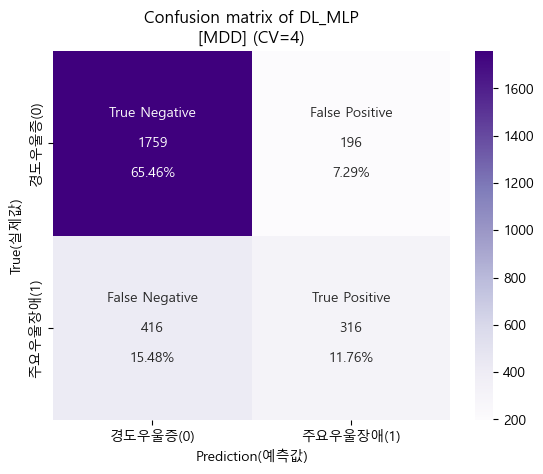

In [128]:
# Confusion matrix (혼동행렬)
cfm_mlp_mdd = confusion_matrix(mlp_val_true_cv, mlp_val_pred_cv)

# 시각화에 표시할 값들을 정의하기
group_names_mlp_mdd = ['True Negative','False Positive','False Negative','True Positive']
group_counts_mlp_mdd = ['{0:0.0f}'.format(value) for value in cfm_mlp_mdd.flatten()]
group_percent_mlp_mdd = ['{0:.2%}'.format(value) for value in cfm_mlp_mdd.flatten()/np.sum(cfm_mlp_mdd)]

labels_mlp_mdd = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_mlp_mdd,
                                                                group_counts_mlp_mdd,
                                                                group_percent_mlp_mdd)]
labels_mlp_mdd = np.asarray(labels_mlp_mdd).reshape(2,2)

tick_mlp_mdd = ['경도우울증(0)', '주요우울장애(1)']

# 시각화(heatmap)
sns.heatmap(cfm_mlp_mdd, annot=labels_mlp_mdd, fmt='', cmap='Purples',
            xticklabels=tick_mlp_mdd, yticklabels=tick_mlp_mdd)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of DL_MLP\n[MDD] (CV=4)")
plt.show()

- ROC_AUC score

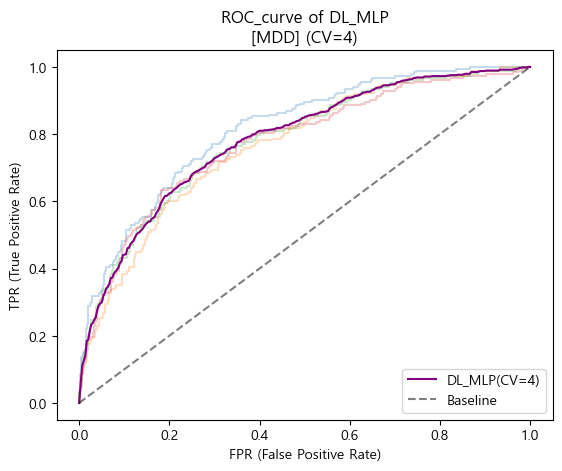

In [129]:
# TPR(True Positive Rate) 리스트
TPRs_mlp_mdd = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_mlp_mdd = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_mdd.predict(X_val_cv, verbose=0).flatten()
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_mdd = np.interp(x=base_FPR_mlp_mdd, xp=FPR, fp=TPR)
    TPR_mdd[0] = 0.0
    TPRs_mlp_mdd.append(TPR_mdd)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_mlp_mdd = np.array(TPRs_mlp_mdd)
mean_TPRs_mlp_mdd = TPRs_mlp_mdd.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_mlp_mdd, mean_TPRs_mlp_mdd,
         label='DL_MLP(CV=4)', color='purple')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of DL_MLP\n[MDD] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [130]:
# ROC_AUC score 산출 (cv=4)
# AUC score를 담을 리스트를 생성
mlp_val_AUC_cv = []

# KFold로 AUC score 산출
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_mlp_mdd.predict(X_val_cv, verbose=0).flatten()
    
    # AUC score 연산, 리스트에 append
    mlp_val_AUC = roc_auc_score(y_val_cv, y_val_prob)
    mlp_val_AUC_cv.append(mlp_val_AUC)

# 평균 AUC score 연산
CV_AUC_mlp_mdd = np.array(mlp_val_AUC_cv).mean()

print("[MDD]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_mdd))
print("DL_MLP AUC score : {:.4f}".format(CV_AUC_mlp_mdd.mean()))

[MDD]
Baseline AUC score : 0.5000
DL_MLP AUC score : 0.7838


#### 2-4. 🛠️ Cross-Validation (Depression)<br>DeepLearning - 1D-CNN (Convolutional Neural Networks)

- Accuracy (정확도)

In [131]:
# Tuning Model 불러오기 (Decoding, 복호화)
model_cnn_mdd = load_model('../tuning-models/CNN_mdd.h5')

# Accuracy score를 담을 리스트를 생성
cnn_val_acc_cv = []

# KFold로 Accuracy Score 산출
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_mdd.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # Accuracy score 연산, 리스트에 append
    cnn_val_acc = accuracy_score(y_val_cv, y_val_pred)
    cnn_val_acc_cv.append(cnn_val_acc)

# 평균 Accuracy score 연산
CV_acc_cnn_mdd = np.array(cnn_val_acc_cv).mean()

print("[MDD]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_mdd))
print("DL_1D-CNN Accuracy : {:.4f}".format(CV_acc_cnn_mdd.mean()))

[MDD]
Baseline Accuracy : 0.7276
DL_1D-CNN Accuracy : 0.7488


- CV Prediction (교차검증 예측)

In [132]:
# MLP와 동일한 방식으로 진행한다
cnn_val_true_cv = np.array([], dtype=int)
cnn_val_pred_cv = np.array([], dtype=int)

# KFold 수행
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_mdd.predict(X_val_cv, verbose=0).flatten()
    y_val_pred = np.where(y_val_prob<0.5, 0, 1)
    
    # true값(Series)를 array로 변환
    y_val_true = np.array(y_val_cv)
    
    # true값과 pred값을 append
    cnn_val_true_cv = np.append(cnn_val_true_cv, y_val_true)
    cnn_val_pred_cv = np.append(cnn_val_pred_cv, y_val_pred)

# Table을 통해 확인해보기
df_pred_cnn_mdd = pd.DataFrame(data={'true_mdd': cnn_val_true_cv,
                                      'pred_mdd': cnn_val_pred_cv})
table_pred_cnn_mdd = pd.crosstab(df_pred_cnn_mdd['true_mdd'],
                                  df_pred_cnn_mdd['pred_mdd'])
display(table_pred_cnn_mdd)

pred_mdd,0,1
true_mdd,,
0,1940,15
1,660,72


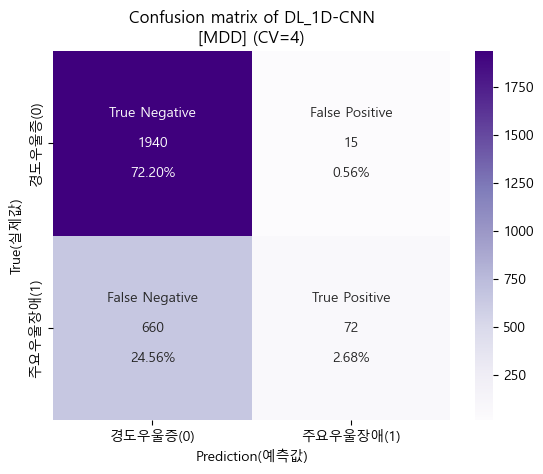

In [133]:
# Confusion matrix (혼동행렬)
cfm_cnn_mdd = confusion_matrix(cnn_val_true_cv, cnn_val_pred_cv)

# 시각화에 표시할 값들을 정의하기
group_names_cnn_mdd = ['True Negative','False Positive','False Negative','True Positive']
group_counts_cnn_mdd = ['{0:0.0f}'.format(value) for value in cfm_cnn_mdd.flatten()]
group_percent_cnn_mdd = ['{0:.2%}'.format(value) for value in cfm_cnn_mdd.flatten()/np.sum(cfm_cnn_mdd)]

labels_cnn_mdd = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_cnn_mdd,
                                                                group_counts_cnn_mdd,
                                                                group_percent_cnn_mdd)]
labels_cnn_mdd = np.asarray(labels_cnn_mdd).reshape(2,2)

tick_cnn_mdd = ['경도우울증(0)', '주요우울장애(1)']

# 시각화(heatmap)
sns.heatmap(cfm_cnn_mdd, annot=labels_cnn_mdd, fmt='', cmap='Purples',
            xticklabels=tick_cnn_mdd, yticklabels=tick_cnn_mdd)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of DL_1D-CNN\n[MDD] (CV=4)")
plt.show()

- ROC_AUC score

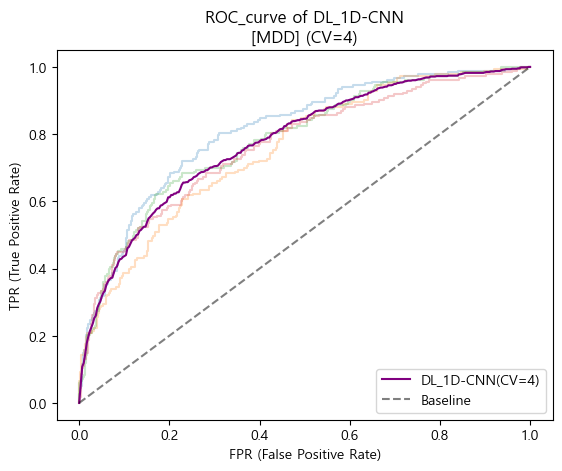

In [134]:
# TPR(True Positive Rate) 리스트
TPRs_cnn_mdd = []
# FPR 축의 정밀도를 계산할 기본 linespace 정의(300개의 값이 들어가도록 설정함)
base_FPR_cnn_mdd = np.linspace(0,1,300)

# Cross-validation 및 ROC curve plotting 실시 (KFold)
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    # Train, Validation Split
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_mdd.predict(X_val_cv, verbose=0).flatten()
    
    # get FRP, TPR
    FPR, TPR, _ = roc_curve(y_val_cv, y_val_prob)    
    # plot ROC curve (투명하게 설정)
    plt.plot(FPR, TPR, alpha=0.25)
    
    # 기본 linespace에 대응하는 TPR array 생성후 값을 append하기
    TPR_mdd = np.interp(x=base_FPR_cnn_mdd, xp=FPR, fp=TPR)
    TPR_mdd[0] = 0.0
    TPRs_cnn_mdd.append(TPR_mdd)

# TPR 리스트를 array로 변환 후 평균값의 array 생성
TPRs_cnn_mdd = np.array(TPRs_cnn_mdd)
mean_TPRs_cnn_mdd = TPRs_cnn_mdd.mean(axis=0)

# 평균 ROC curve plotting    
plt.plot(base_FPR_cnn_mdd, mean_TPRs_cnn_mdd,
         label='DL_1D-CNN(CV=4)', color='purple')
# Baseline plotting
plt.plot([0,1],[0,1], label='Baseline', color='black', linestyle='--', alpha=0.5)

# plot 설정
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title("ROC_curve of DL_1D-CNN\n[MDD] (CV=4)")
plt.legend(loc='lower right')
plt.show()

In [135]:
# ROC_AUC score 산출 (cv=4)
# AUC score를 담을 리스트를 생성
cnn_val_AUC_cv = []

# KFold로 AUC score 산출
for train_idx, val_idx in kf_4.split(X_train_mdd, y_train_mdd):
    X_train_cv, X_val_cv = X_train_mdd.iloc[train_idx], X_train_mdd.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_mdd.iloc[train_idx], y_train_mdd.iloc[val_idx]
    
    # Prediction 실시
    y_val_prob = model_cnn_mdd.predict(X_val_cv, verbose=0).flatten()
    
    # AUC score 연산, 리스트에 append
    cnn_val_AUC = roc_auc_score(y_val_cv, y_val_prob)
    cnn_val_AUC_cv.append(cnn_val_AUC)

# 평균 AUC score 연산
CV_AUC_cnn_mdd = np.array(cnn_val_AUC_cv).mean()

print("[MDD]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_mdd))
print("DL_1D-CNN AUC score : {:.4f}".format(CV_AUC_cnn_mdd.mean()))

[MDD]
Baseline AUC score : 0.5000
DL_1D-CNN AUC score : 0.7786


#### 3-1. 📊 Compare Models Performance (모델 성능 비교분석)

- Accuracy & AUC score 비교 데이터 생성

In [136]:
# 성능 비교를 위한 DataFrame 정의
df_score_mdd = pd.DataFrame({'Accuracy':[baseline_acc_mdd,
                                          CV_acc_logistic_mdd.mean(),
                                          CV_acc_lgbm_mdd.mean(),
                                          CV_acc_mlp_mdd,
                                          CV_acc_cnn_mdd],
                              'AUC_score':[baseline_AUC_mdd,
                                           CV_AUC_logistic_mdd.mean(),
                                           CV_AUC_lgbm_mdd.mean(),
                                           CV_AUC_mlp_mdd,
                                           CV_AUC_cnn_mdd]},
                             index=['Baseline', 'Logistic', 'LightGBM', 'DL_MLP', 'DL_1D-CNN'])\
                            .sort_values(by='AUC_score',ascending=True)
display(df_score_mdd)

,Accuracy,AUC_score
Baseline,0.727577,0.500000
LightGBM,0.757346,0.740004
Logistic,0.765908,0.750014
DL_1D-CNN,0.748791,0.778619
DL_MLP,0.772238,0.783781


- 평가지표 시각화 (bar-plot)

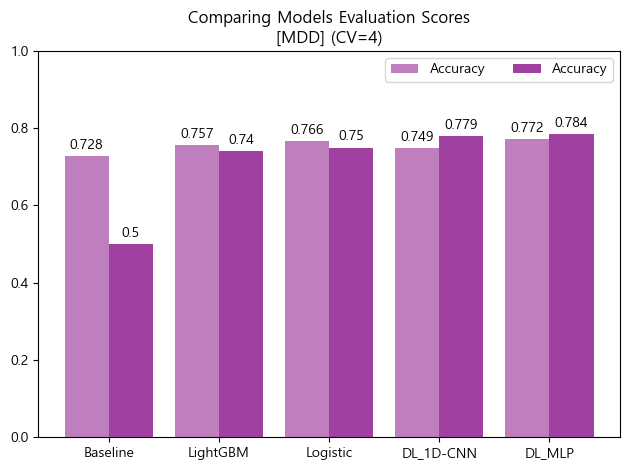

In [137]:
# 검증 스코어 시각화
x_mdd = np.arange(len(df_score_mdd))
width_mdd = 0.4

# subplot 정의
fig_mdd, ax_mdd = plt.subplots()
# Accuracy bar
rect1 = ax_mdd.bar(x= x_mdd - width_mdd/2,
                    height=df_score_mdd.Accuracy.round(3),
                    width=width_mdd,
                    label='Accuracy',
                    color='purple', alpha=0.5)
# AUC score bar
rect2 = ax_mdd.bar(x= x_mdd + width_mdd/2,
                    height=df_score_mdd.AUC_score.round(3),
                    width=width_mdd,
                    label='Accuracy',
                    color='purple', alpha=0.75)

# plot 설정
ax_mdd.set_title("Comparing Models Evaluation Scores\n[MDD] (CV=4)")
ax_mdd.set_xticks(x_mdd, df_score_mdd.index)
ax_mdd.bar_label(rect1, padding=3)
ax_mdd.bar_label(rect2, padding=3)
fig_mdd.tight_layout()
plt.ylim([0,1])
plt.legend(ncol=2)
plt.show()

- ROC curves 시각화

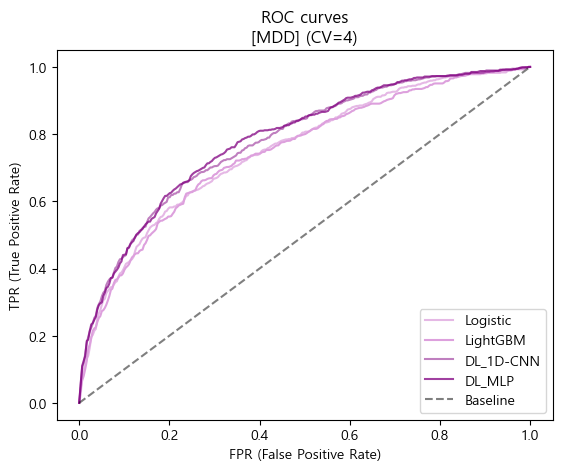

In [138]:
# CV 평균 ROC curve를 비교하기 위한 시각화
plt.plot(base_FPR_logistic_mdd, mean_TPRs_logistic_mdd,
         label='Logistic', color='plum', alpha=0.75)
plt.plot(base_FPR_lgbm_mdd, mean_TPRs_lgbm_mdd,
         label='LightGBM', color='plum', alpha=1)
plt.plot(base_FPR_cnn_mdd, mean_TPRs_cnn_mdd,
         label='DL_1D-CNN', color='purple', alpha=0.5)
plt.plot(base_FPR_mlp_mdd, mean_TPRs_mlp_mdd,
         label='DL_MLP', color='purple', alpha=0.75)
plt.plot([0,1],[0,1], label='Baseline', linestyle='--', color='black', alpha=0.5)
plt.title('ROC curves\n[MDD] (CV=4)')
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.legend(loc='lower right')
plt.show()

#### 3-2. 🏆 Final Model Selection (최종 모델 선정)
- 모델들 모두 Baseline에 비해선 Accuracy score와 AUC score가 높게 나타남
- 모델들 중에선 Accuracy score와 AUC score 모두 MLP 모델이 가장 높은 성능을 나타냈음
    - Depression과 비교했을 때 튜닝과정에서 1D-CNN모델에서 과적합이 발생한 것이 원인이 아닐까 유추해봄 (파라미터 수가 36만개나 되었으므로..)

- 🏆 따라서 MDD(경도우울증vs주요우울장애)에서는 "MLP 모델"을 최종 모델로 선정

#### 3-3. 📝 Final Model Test (최종 모델 테스트)
- 학습에 이용되지 않았던 Test Dataset을 통해 일반화 가능성을 최종적으로 검증

In [139]:
# Test Data Prediction
y_test_prob_mdd = model_mlp_mdd.predict(X_test_mdd, verbose=0).flatten()
y_test_pred_mdd = np.where(y_test_prob_mdd<0.5, 0, 1)

# Table을 통해 확인해보기
df_test_mdd = pd.DataFrame(data={'true_mdd': y_test_mdd,
                                   'pred_mdd': y_test_pred_mdd})
table_test_mdd = pd.crosstab(df_test_mdd['true_mdd'],
                              df_test_mdd['pred_mdd'])
display(table_test_mdd)

pred_mdd,0,1
true_mdd,,
0,428,60
1,113,71


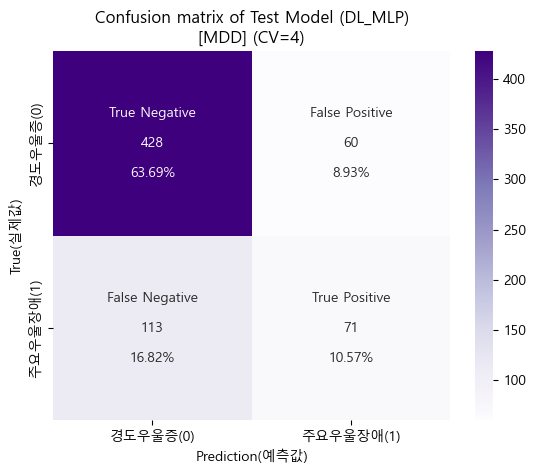

In [140]:
# Confusion matrix (혼동행렬)
cfm_test_mdd = confusion_matrix(y_test_mdd, y_test_pred_mdd)

# 시각화에 표시할 값들을 정의하기
group_names_test_mdd = ['True Negative','False Positive','False Negative','True Positive']
group_counts_test_mdd = ['{0:0.0f}'.format(value) for value in cfm_test_mdd.flatten()]
group_percent_test_mdd = ['{0:.2%}'.format(value) for value in cfm_test_mdd.flatten()/np.sum(cfm_test_mdd)]

labels_test_mdd = [f'{v1}\n\n{v2}\n\n{v3}' for v1,v2,v3 in zip(group_names_test_mdd,
                                                                group_counts_test_mdd,
                                                                group_percent_test_mdd)]
labels_test_mdd = np.asarray(labels_test_mdd).reshape(2,2)

tick_test_mdd = ['경도우울증(0)', '주요우울장애(1)']

# 시각화(heatmap)
sns.heatmap(cfm_test_mdd, annot=labels_test_mdd, fmt='', cmap='Purples',
            xticklabels=tick_test_mdd, yticklabels=tick_test_mdd)
plt.xlabel("Prediction(예측값)")
plt.ylabel("True(실제값)")
plt.title("Confusion matrix of Test Model (DL_MLP)\n[MDD] (CV=4)")
plt.show()

In [142]:
# Test Model Accuracy Score
score_acc_test_mdd = accuracy_score(y_test_mdd, y_test_pred_mdd)
print("[MDD]")
print("Baseline Accuracy : {:.4f}".format(baseline_acc_mdd))
print("Validation Accuracy (cv=4) : {:.4f}".format(CV_acc_mlp_mdd))
print("Test Accuracy : {:.4f}".format(score_acc_test_mdd))

[MDD]
Baseline Accuracy : 0.7276
Validation Accuracy (cv=4) : 0.7722
Test Accuracy : 0.7426


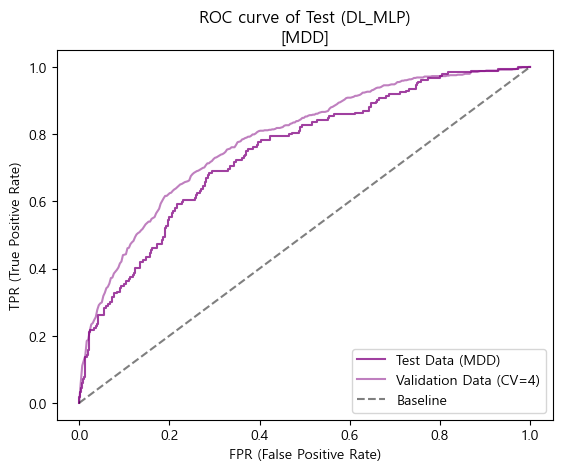

In [144]:
# ROC curve 시각화
FPR_test_mdd, TPR_test_mdd, _ = roc_curve(y_test_mdd, y_test_prob_mdd)
plt.plot(FPR_test_mdd, TPR_test_mdd,
         label='Test Data (MDD)', color='purple', alpha=0.75)
plt.plot(base_FPR_mlp_mdd, mean_TPRs_mlp_mdd,
         label='Validation Data (CV=4)', color='purple', alpha=0.5)
plt.plot([0,1],[0,1], linestyle='--',
         label='Baseline', color='black', alpha=0.5)
plt.title("ROC curve of Test (DL_MLP)\n[MDD]")
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.legend(loc='lower right')
plt.show()

In [145]:
# Test Model AUC Score
score_AUC_test_mdd = roc_auc_score(y_test_mdd, y_test_prob_mdd)
print("[MDD]")
print("Baseline AUC score : {:.4f}".format(baseline_AUC_mdd))
print("Validation AUC score (cv=4) : {:.4f}".format(CV_AUC_mlp_mdd))
print("Test AUC score : {:.4f}".format(score_AUC_test_mdd))

[MDD]
Baseline AUC score : 0.5000
Validation AUC score (cv=4) : 0.7838
Test AUC score : 0.7469


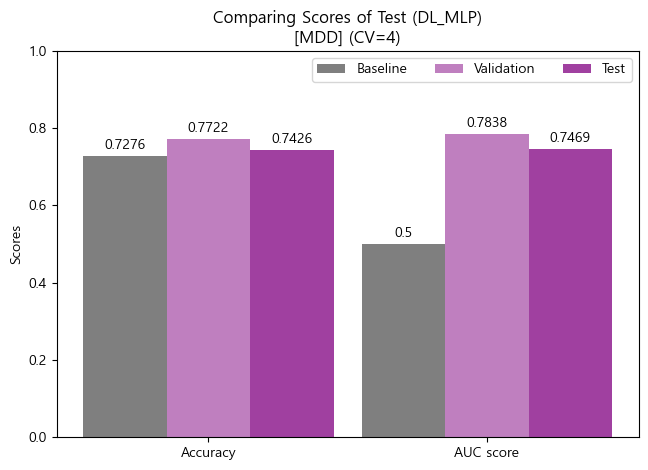

In [147]:
# Test Model 평가지표 시각화 (bar-plot)
df_test_mlp_mdd = pd.DataFrame({'Baseline':[baseline_acc_mdd,
                                             baseline_AUC_mdd],
                                 'Validation':[CV_acc_mlp_mdd,
                                               CV_AUC_mlp_mdd],
                                 'Test':[score_acc_test_mdd,
                                         score_AUC_test_mdd]},
                                index=['Accuracy', 'AUC score'])
x_mlp_mdd = np.arange(len(df_test_mlp_mdd))
width_mlp_mdd = 0.3

# subplot 정의
fig_mlp_mdd, ax_mlp_mdd = plt.subplots()
# Baseline bar
rect1 = ax_mlp_mdd.bar(x= x_mlp_mdd - width_mlp_mdd,
                        height=df_test_mlp_mdd.Baseline.round(4),
                        width=width_mlp_mdd,
                        label='Baseline',
                        color='black', alpha=0.5)
# Validation bar
rect2 = ax_mlp_mdd.bar(x= x_mlp_mdd,
                        height=df_test_mlp_mdd.Validation.round(4),
                        width=width_mlp_mdd,
                        label='Validation',
                        color='purple', alpha=0.5)
# Test bar
rect3 = ax_mlp_mdd.bar(x= x_mlp_mdd + width_mlp_mdd,
                        height=df_test_mlp_mdd.Test.round(4),
                        width=width_mlp_mdd,
                        label='Test',
                        color='purple', alpha=0.75)

# plot 설정
ax_mlp_mdd.set_title("Comparing Scores of Test (DL_MLP)\n[MDD] (CV=4)")
ax_mlp_mdd.set_xticks(x_mlp_mdd, df_test_mlp_mdd.index)
ax_mlp_mdd.bar_label(rect1, padding=3)
ax_mlp_mdd.bar_label(rect2, padding=3)
ax_mlp_mdd.bar_label(rect3, padding=3)
fig_mlp_mdd.tight_layout()
plt.ylabel("Scores")
plt.ylim([0,1])
plt.legend(ncol=3)
plt.show()

💡 Final Model Test 일반화 가능성
- MDD(경도우울증vs주요우울장애)의 최종 모델인 MLP 모델에 대하여 테스트 데이터셋으로 일반화 가능성을 최종적으로 검증하였음
- 테스트 결과, Validation 데이터에 비해 Test 데이터의 Accuracy와 AUC score가 다소 낮게 나타났지만, Sample수의 차이와 Baseline의 수치를 고려해보았을 때, 일반화 가능성이 그래도 높은 모델이라 판단해 볼 수 있음.
---